# Reservoirs tables - EFAS
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 16-01-2025<br>

**Introduction:**<br>

* [x] 100-year return period of inflow
* [x] average inflow
* [ ] environmental flow?
* [x] storage capacity
* [x] catchment area
* [ ] reservoir area: it would be necessary if we want to model the reservoir surface area
* [ ] elevation crest: it would be necessary if we want to model the reservoir level
* [ ] dam height: it would be necessary if we want to model the reservoir level

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime

import sys
sys.path.append('E:/casadje/GitHub/lisflood-utilities/src/')
from lisfloodutilities.thresholds import compute_thresholds_gumbel

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from lisfloodreservoirs.utils.plots import plot_reservoir_map, compare_attributes

In [4]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

## Configuration

In [5]:
# paths
PATH_EFAS5 = Path('Z:/nahaUsers/casadje/EFASv5')
PATH_EFAS6 = Path('Z:/nahaUsers/casadje/EFASv6')
PATH_OUT = PATH_EFAS6 / 'reservoirs' / 'tables'
PATH_OUT.mkdir(parents=True, exist_ok=True)

# minimum storage capacity included in EFAS
MIN_VOLUME = 10 # hm³
MIN_AREA = 50 # km²
MIN_DOR = 0.08 # 

## Data

### EFAS6

I load a shapefile with the manual selection of reservoirs to be included in EFASv6, which have already been located in the LISFLOOD grid.

In [6]:
# import shapefile
# reservoirs = gpd.read_file(PATH_EFAS6 / 'reservoirs' / 'reservoirEfasV6.shp')
efas6 = gpd.read_file(PATH_EFAS6 / 'reservoirs' / 'efas6_reservoirs.shp')
efas6.GRanD_id = efas6.GRanD_id.astype('Int64')
efas6.Hylak_id = efas6.Hylak_id.astype('Int64')
efas6.ResID = efas6.ResID.astype('Int64')

# assing ID in descending order of storage capacity
efas6.sort_values('CAP_MCM', ascending=False, inplace=True)
efas6.reset_index(drop=True, inplace=True)
efas6.index.name = 'ID'
efas6.drop('ID', axis=1, errors='ignore', inplace=True)
efas6 = efas6[['ResID', 'GRanD_id', 'Hylak_id', 'ICOLD_id', 'geometry']]
# efas6['ID'] = efas6.index

### EFAS5

#### Reservoirs

In [7]:
efas5 = gpd.read_file(PATH_EFAS5 / 'tables' / 'EFAS5_reservoirs.shp')#.set_index('ResID')

# assign ID
map_efas_ID = {ResID: ID for ID, ResID in zip(efas6.index, efas6.ResID) if not pd.isna(ResID)}
efas5['ID'] = efas5.ResID.map(map_efas_ID).astype('Int64')

# filter reservoirs in EFAS5 also in EFAS6
efas5.dropna(subset=['ID'], inplace=True)
efas5.set_index('ID', drop=False, inplace=True)

print(efas5.shape)

(1393, 34)


#### Static maps

In [8]:
# load the upstream area map
uparea = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'upArea_European_01min.nc').squeeze(dim='band')
uparea = uparea.where(uparea != -999999, np.nan)

#### Natural flow

I have run the tool `ncextract` on the EFASv5 long-term run simulation with natural flow, i.e, no reservoirs and no water abstraction. The discharge files resulting from this simulation are in the HPC: `/mnt/DISASTER/FLOODS/nahaUsers/grimast/EFASNatflow/`.

The discharge time series extracted for the reservoir locations are proxies of the reservoir inflow. From these time series we need to estimate the 100-year return period, average inflow and environmental flow.

In [9]:
# export CSV needed to run `ncextract`
points = pd.concat((efas6.geometry.x, efas6.geometry.y), axis=1)
points.columns = ['lon', 'lat']
points.to_csv(PATH_EFAS6 / 'reservoirs' / 'ncextract' / 'reservoirs_efas6_1545.csv')

In [10]:
# daily timeseries of naturalised discharge
dis_nat = xr.open_dataset(PATH_EFAS6 / 'reservoirs' / 'ncextract' / 'nat_dis_EFAS5_1545.nc')['dis']
dis_nat = dis_nat.sel(time=slice('1993-01-02', None))
dis_nat.close()

In [11]:
# 10th percentile of the natural flow
dis_env_nat = xr.open_dataset(PATH_EFAS5 / 'natural_flow' / 'dis_all20_pctl10.nc')['dis'].squeeze('time')

#### Long-term run
Average discharge in the EFAS5 long-term run.

In [12]:
# average discharge
dis_avg_ltr = rxr.open_rasterio(PATH_EFAS5 / 'long_run' / 'disavg_1992_2023.nc').squeeze(dim='time')
dis_avg_ltr.close()

In [13]:
# 100-year discharge
dis_100_ltr = rxr.open_rasterio(PATH_EFAS5 / 'long_run' / 'flood_threshold_efas_v5.1_rl_100.0.nc').squeeze(dim='band')

### GRanD

In [14]:
grand = gpd.read_file(PATH_EFAS6 / 'reservoirs' / 'GRanD' / 'grand_dams.shp')

# connection between GRanD_id and ID
map_grand_ID = {grand_id: ID for ID, grand_id in zip(efas6.index, efas6.GRanD_id) if not pd.isna(grand_id)}
grand['ID'] = grand.GRAND_ID.map(map_grand_ID).astype('Int64')
grand.rename(columns={'GRAND_ID': 'GRanD_id'}, inplace=True)
grand.set_index('GRanD_id', drop=True, inplace=True)

print(grand.shape)

(1575, 62)


### ICOLD

In [15]:
icold = gpd.read_file(PATH_EFAS6 / 'reservoirs' / 'ICOLD' / 'icold.shp')#.set_index('Int_Code')

# connection between ICOLD and ID
map_icold_ID = {icold_id: ID for ID, icold_id in zip(efas6.index, efas6.ICOLD_id) if not pd.isna(icold_id)}
icold['ID'] = icold.Int_Code.map(map_icold_ID).astype('Int64')
icold.set_index('Int_Code', drop=True, inplace=True)

print(icold.shape)

(7887, 46)


### HydroLakes

In [16]:
# hylak = gpd.read_file(PATH_EFAS6 / 'reservoirs' / 'HydroLakes' / 'hydrolakes_dams.shp').set_index('Hylak_id')
hylak = gpd.read_file(PATH_EFAS6 / 'lakes' / 'hydrolakes_domain.shp').set_index('Hylak_id', drop=True)
hylak.Grand_id = hylak.Grand_id.replace(0, np.nan)

# connection between GRanD and ID
map_hylak_ID = {hylak_id: ID for ID, hylak_id in zip(efas6.index, efas6.Hylak_id) if not pd.isna(hylak_id)}
hylak['ID'] = hylak.index.map(map_hylak_ID)
# hylak.set_index('Hylak_id', drop=True, inplace=True)
hylak = hylak[hylak.ID.notnull() | hylak.Grand_id.notnull()]

## Attributes
### Capacity

In [17]:
capacity = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'GRAND', 'ICOLD', 'HYLAK', 'EFAS6', 'SOURCE'], dtype=float)
capacity.SOURCE = capacity.SOURCE.astype(str)

# EFAS5
capacity.loc[efas5.index, 'EFAS5'] = efas5.tstor

# GRanD
# capacity.loc[efas6.index, 'GRAND'] = efas6.CAP_MCM
mask = grand.ID.notnull()
capacity.loc[grand.loc[mask, 'ID'], 'GRAND'] = grand.loc[mask, 'CAP_MCM'].values

# ICOLD
# capacity.loc[efas5.index, 'ICOLD'] = efas5.ICOLD_VOL
mask = icold.ID.notnull()
capacity.loc[icold.loc[mask, 'ID'], 'ICOLD'] = icold.loc[mask, 'Res_Vol'].values

# HydroLakes
mask = hylak.ID.notnull()
capacity.loc[hylak.loc[mask, 'ID'], 'HYLAK'] = hylak.loc[mask, 'Vol_res'].values

#### Comparison

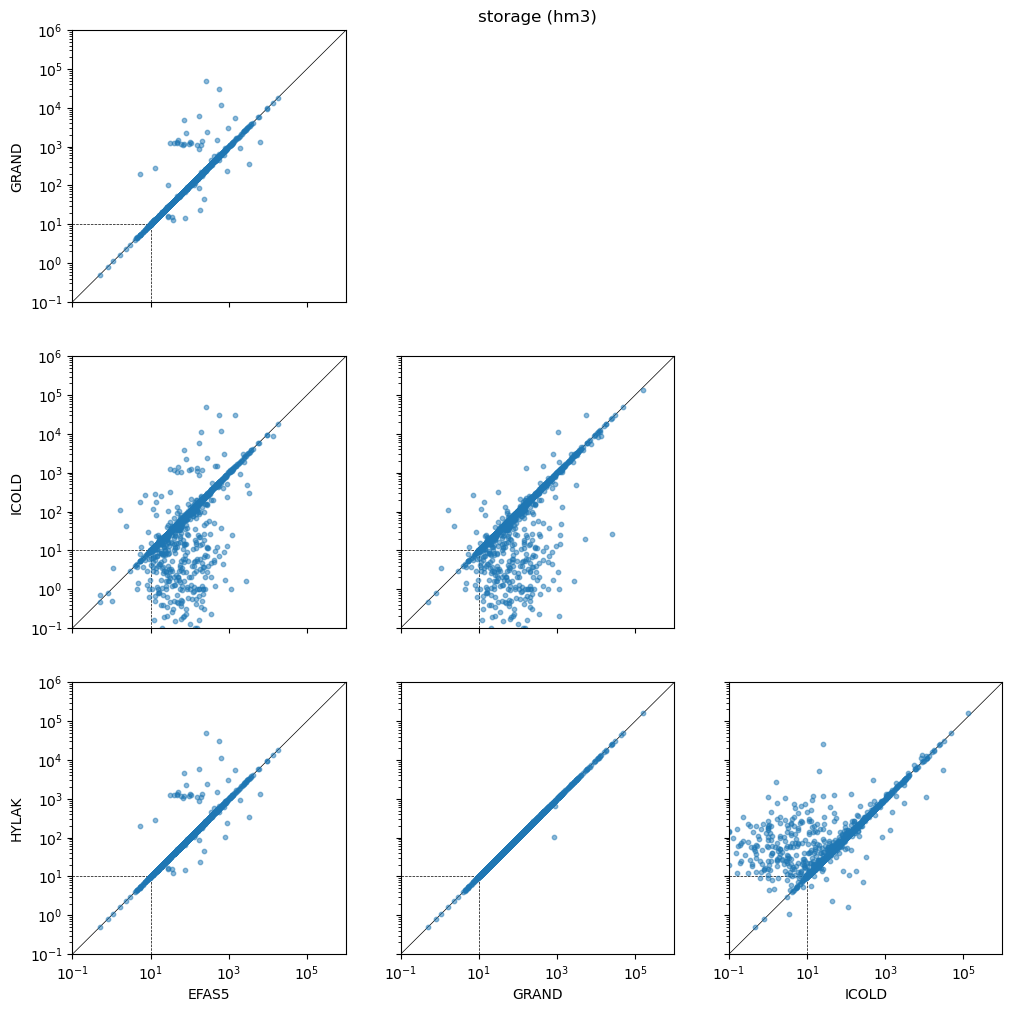

In [18]:
compare_attributes(
    capacity[['EFAS5', 'GRAND', 'ICOLD', 'HYLAK']],
    thr=MIN_VOLUME,
    vmin=1e-1,
    vmax=1e6,
    title='storage (hm3)'
)
plt.savefig(PATH_OUT / 'plots' / 'storage_pairplot.jpg', dpi=300, bbox_inches='tight')

In [19]:
# error = 2
# mask_error = (capacity.GRAND < capacity.EFAS5 / error) | (capacity.GRAND > error * capacity.EFAS5)
# print(mask_error.sum())
# capacity[mask_error]

#### Select values

I have manually checked the large discrepancies between EFAS5 and GRanD. In case of discrepancy, I compare with ICOLD and HydroLakes. It seems like GRanD is a more reliable source, so I will use the value from GRanD whenever possible, if not the value from EFAS5.

54 reservoirs do not comply with the minimum storage of 10 hm3


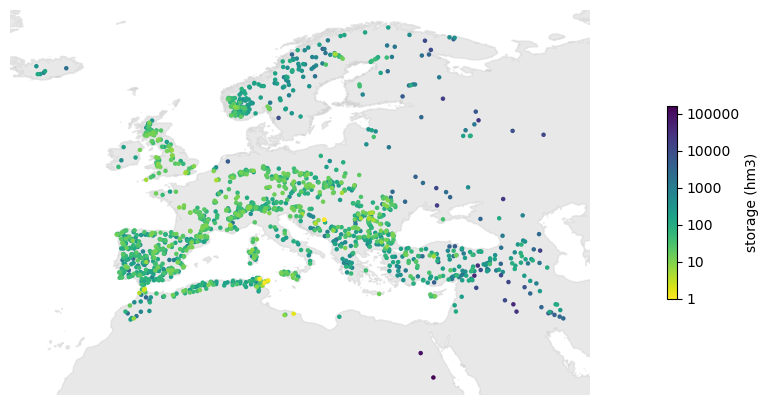

In [20]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
for source in ['GRAND', 'EFAS5', 'HYLAK', 'ICOLD']:
    missing = capacity.EFAS6.isnull()
    mask = capacity[source].notnull()
    capacity.loc[missing & mask, 'EFAS6'] = capacity.loc[missing & mask, source]
    capacity.loc[missing & mask, 'SOURCE'] = source

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=np.log10(capacity.EFAS6),
    cmap='viridis_r',
    s=5,
    vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='storage (hm3)')
ticks = [0, 1, 2, 3, 4, 5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'storage_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[capacity.index, ['CAP_MCM', 'CAP_SRC']] = capacity[['EFAS6', 'SOURCE']].values

print('{0} reservoirs do not comply with the minimum storage of {1} hm3'.format((efas6.CAP_MCM < MIN_VOLUME).sum(),
                                                                                MIN_VOLUME))

### Catchment area

In [21]:
catchment = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'UPAREA', 'GRAND', 'ICOLD', 'HYLAK', 'EFAS6', 'SOURCE'], dtype=float)
catchment.SOURCE = catchment.SOURCE.astype(str)

# EFAS5
catchment.loc[efas5.index, 'EFAS5'] = efas5['area']

# upstream area map
for ID, point in efas6.geometry.items():
    catchment.loc[ID, 'UPAREA'] = uparea.sel(x=point.x, y=point.y, method='nearest').item() * 1e-6

# GRanD
mask = grand.ID.notnull()
catchment.loc[grand.loc[mask, 'ID'], 'GRAND'] = grand.loc[mask, 'CATCH_SKM'].values

# ICOLD
# catchment.loc[efas5.index, 'ICOLD'] = efas5.ICOLD_AREA
mask = icold.ID.notnull()
catchment.loc[icold.loc[mask, 'ID'], 'ICOLD'] = icold.loc[mask, 'Catch_Area'].values

# HydroLakes
mask = hylak.ID.notnull()
catchment.loc[hylak.loc[mask, 'ID'], 'HYLAK'] = hylak.loc[mask, 'Wshd_area'].values

#### Comparison

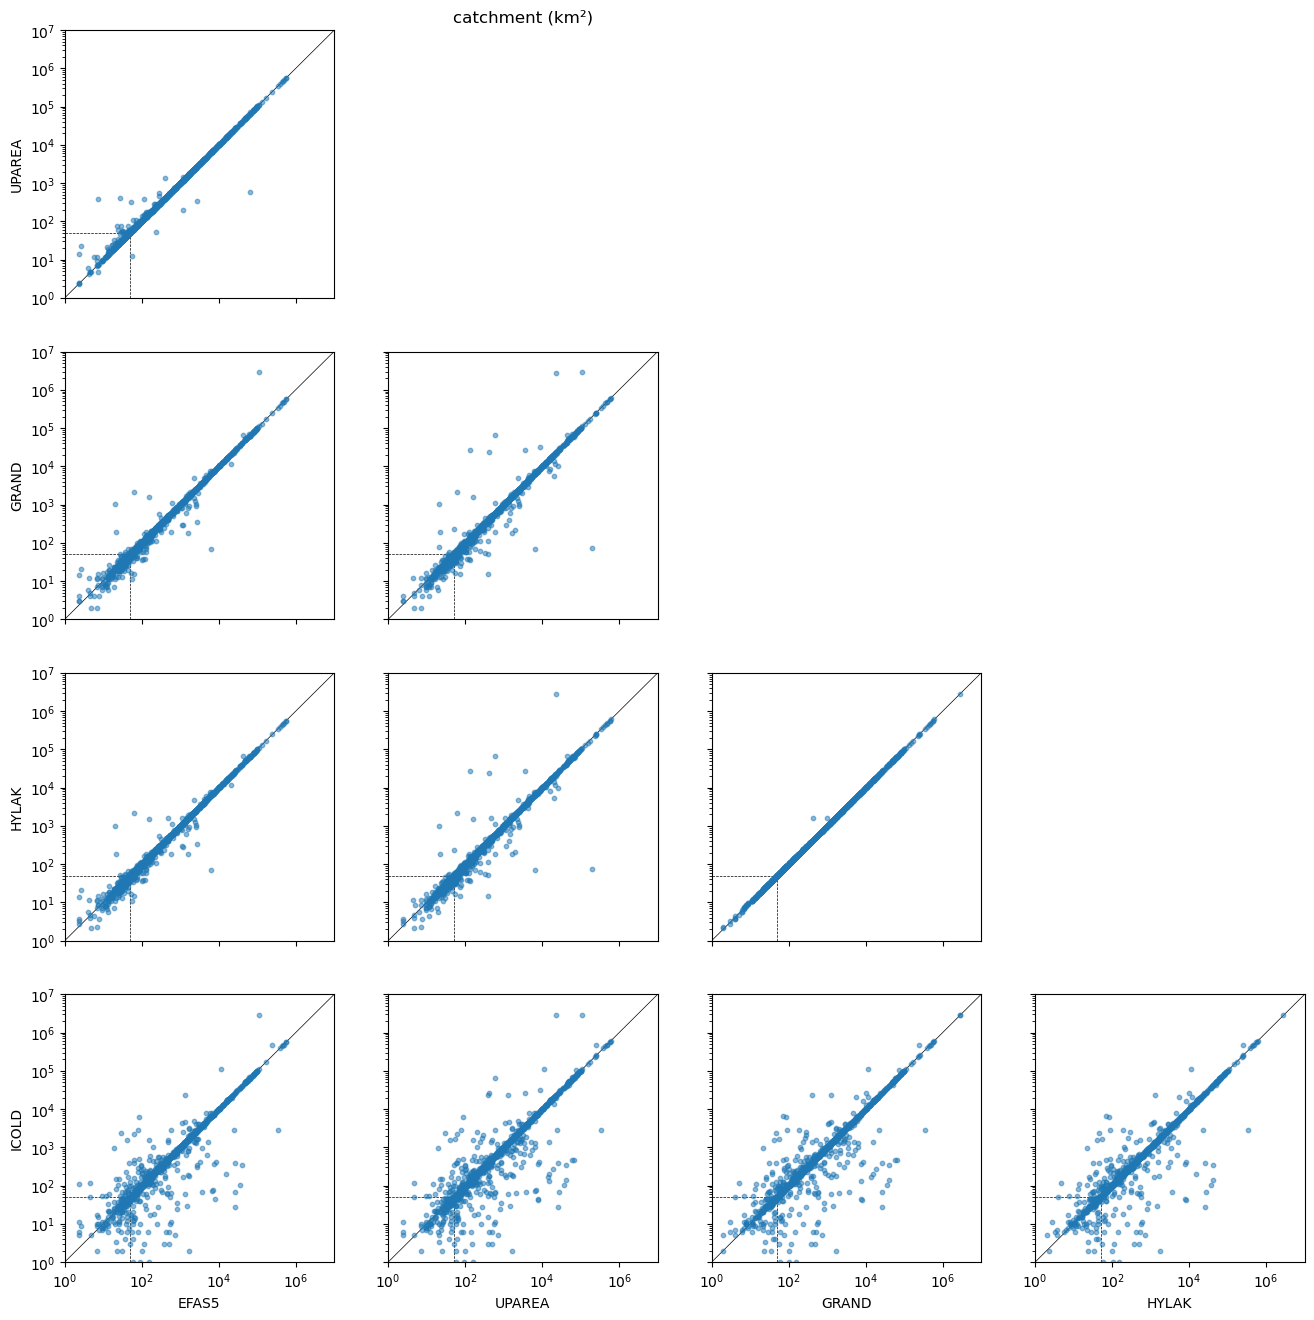

In [22]:
compare_attributes(
    catchment[['EFAS5', 'UPAREA', 'GRAND', 'HYLAK', 'ICOLD']],
    thr=MIN_AREA,
    vmin=1,
    vmax=1e7,
    title='catchment (km²)'
)
plt.savefig(PATH_OUT / 'plots' / 'catchment_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values

Following the procedure applied for the storage capacity, I will use the GRanD value when available.

235 reservoirs do not comply with the minimum catchment area of 50 km²


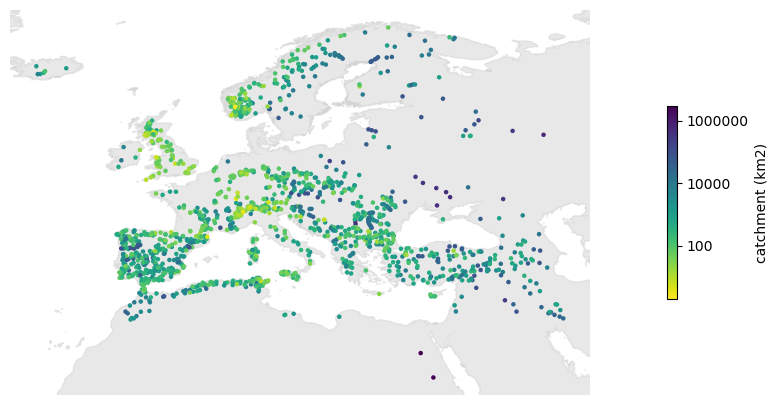

In [23]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
for source in ['GRAND', 'EFAS5', 'HYLAK', 'ICOLD', 'UPAREA']:
    missing = catchment.EFAS6.isnull()
    mask = catchment[source].notnull()
    catchment.loc[missing & mask, 'EFAS6'] = catchment.loc[missing & mask, source]
    catchment.loc[missing & mask, 'SOURCE'] = source

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=np.log10(catchment.EFAS6),
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='catchment (km2)')
ticks = [2, 4, 6]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'catchment_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[catchment.index, ['CATCH_SKM', 'CATCH_SRC']] = catchment[['EFAS6', 'SOURCE']].values
print('{0} reservoirs do not comply with the minimum catchment area of {1} km²'.format((efas6.CATCH_SKM < MIN_CATCHMENT).sum(),
                                                                                       MIN_CATCHMENT))

### Surface area

In [24]:
area = pd.DataFrame(index=efas6.index, columns=['GRAND', 'ICOLD', 'HYLAK', 'EFAS6', 'SOURCE'], dtype=float)
area.SOURCE = area.SOURCE.astype(str)

# GRanD
mask = grand.ID.notnull()
area.loc[grand.loc[mask, 'ID'], 'GRAND'] = grand.loc[mask, 'AREA_SKM'].values

# ICOLD
mask = icold.ID.notnull()
area.loc[icold.loc[mask, 'ID'], 'ICOLD'] = icold.loc[mask, 'Res_Area'].values * 1e-3

# HydroLakes
mask = hylak.ID.notnull()
area.loc[hylak.loc[mask, 'ID'], 'HYLAK'] = hylak.loc[mask, 'Lake_area'].values

#### Comparison

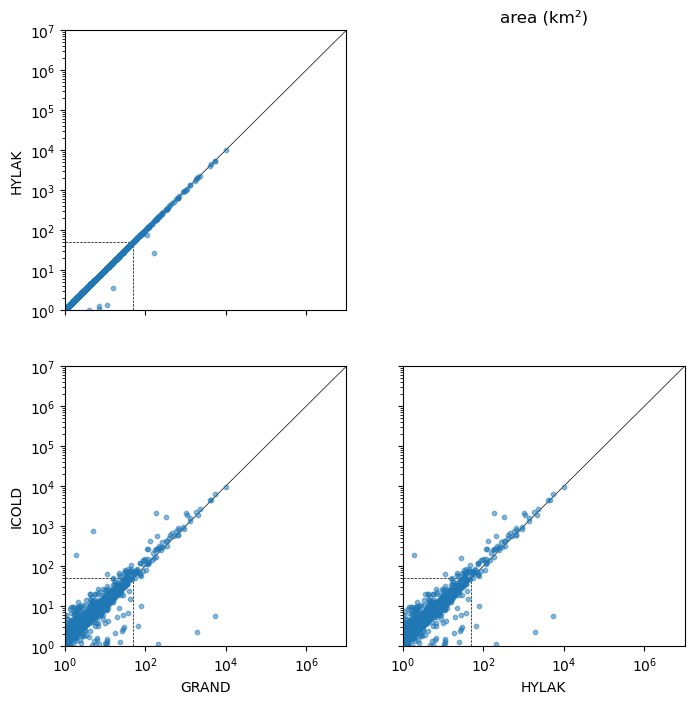

In [25]:
compare_attributes(
    area[['GRAND', 'HYLAK', 'ICOLD']],
    thr=MIN_AREA,
    vmin=1,
    vmax=1e7,
    title='area (km²)'
)
plt.savefig(PATH_OUT / 'plots' / 'area_pairplot.jpg', dpi=300, bbox_inches='tight')

There is a eror in the units in some ICOLD values.

#### Select values

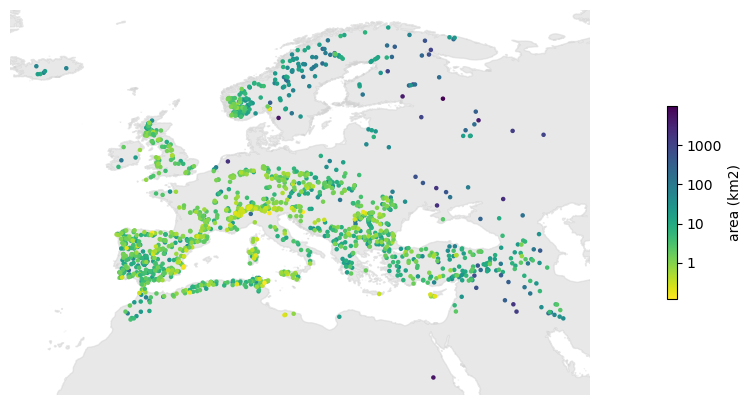

In [26]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
for source in ['GRAND', 'HYLAK', 'ICOLD']:
    missing = area.EFAS6.isnull()
    mask = area[source].notnull()
    area.loc[missing & mask, 'EFAS6'] = area.loc[missing & mask, source]
    area.loc[missing & mask, 'SOURCE'] = source

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=np.log10(area.EFAS6),
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='area (km2)')
ticks = [0, 1, 2, 3]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'area_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[area.index, ['AREA_SKM', 'AREA_SRC']] = area[['EFAS6', 'SOURCE']].values

### Mean inflow

I do not include the values reported in HydroLakes (`Dis_avg`) because they are identical to those in GRanD.

In [27]:
dis_avg = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'NAT_FLOW', 'LTR', 'GRAND', 'EFAS6', 'SOURCE'], dtype=float)
dis_avg.SOURCE = dis_avg.SOURCE.astype(str)

# EFAS5 reservoir parameter
dis_avg.loc[efas5.index, 'EFAS5'] = efas5.normq

# EFAS5 natural flow
dis_avg['NAT_FLOW'] = dis_nat.mean('time').to_pandas()

# EFAS5 long-run average
for ID, point in efas6.geometry.items():
    dis_avg.loc[ID, 'LTR'] = dis_avg_ltr.sel(x=point.x, y=point.y, method='nearest').item()

# GRanD
mask = grand.ID.notnull()
dis_avg.loc[grand.loc[mask, 'ID'], 'GRAND'] = grand.loc[mask, 'DIS_AVG_LS'].values * 1e-3

# HydroLakes
mask = hylak.ID.notnull()
dis_avg.loc[hylak.loc[mask, 'ID'], 'HYLAK'] = hylak.loc[mask, 'Dis_avg'].values

#### Comparison

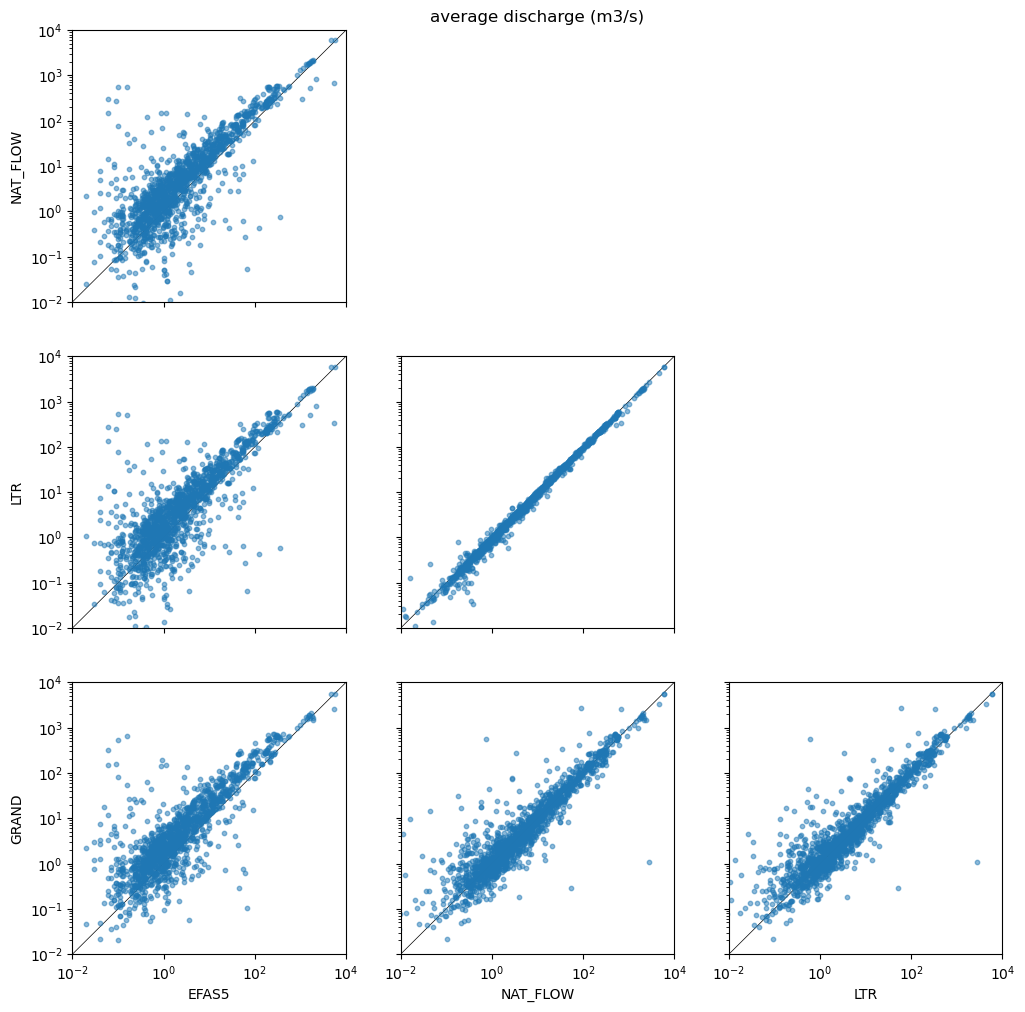

In [28]:
compare_attributes(
    dis_avg[['EFAS5', 'NAT_FLOW', 'LTR', 'GRAND']],
    thr=0,
    vmin=0.01,
    vmax=1e4,
    title='average discharge (m3/s)'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_pairplot.jpg', dpi=300, bbox_inches='tight')

Some reservoirs have average flow surprisingly small. 390 reservoirs have a "natural" average inflow below 1 m3/s. That number was 534 for EFAS5, and 355 in GRanD. These low values indirectly affect the reservoirs that will be modelled as lakes, as the degree of regulation is the reservoir volume divided by the average inflow.

#### Select values
Despite the previous concern, I will use in all cases the naturalised average inflow.

377 reservoirs have an average inflow below 1 m3/s


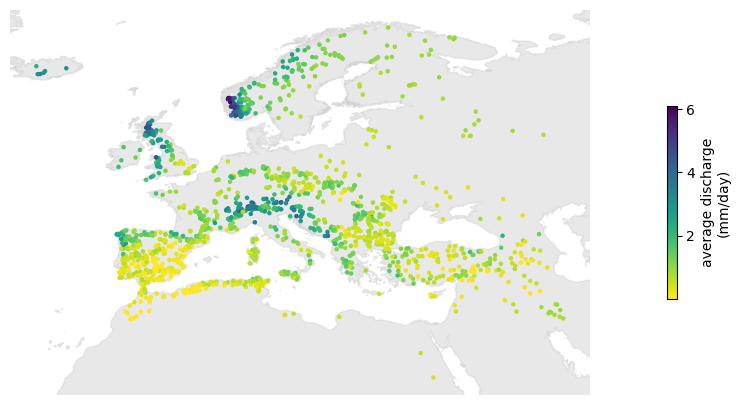

In [30]:
# select values from the EFAS5 naturalised run
dis_avg.EFAS6 = dis_avg.NAT_FLOW
dis_avg.SOURCE = 'EFAS5_nat'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=dis_avg.EFAS6 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='average discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[dis_avg.index, 'DISAVG_CMS'] = dis_avg['EFAS6'].round(1).values

print('{0} reservoirs have an average inflow below 1 m3/s'.format((efas6.DISAVG_CMS < 1).sum()))

### Degree of regulation

The degree of regulation is the amount of annual inflow that the reservoir can store. I'll cap this value to 10,000 years (same as GRanD does), since it's not feasible that a reservoir was designed to store that amount of water.

In [31]:
dor = pd.DataFrame(index=efas6.index, columns=['EFAS6', 'GRAND', 'HYLAK'], dtype=float)

# EFAS6
dor['EFAS6'] = np.minimum(efas6.CAP_MCM * 1e6 / (efas6.DISAVG_CMS  * 24 * 3600 * 365), 1e4)

# GRanD
mask = grand.ID.notnull()
dor.loc[grand.loc[mask, 'ID'], 'GRAND'] = grand.loc[mask, 'DOR'].values

# HydroLakes
mask = hylak.ID.notnull()
dor.loc[hylak.loc[mask, 'ID'], 'HYLAK'] = hylak.loc[mask, 'dor_pc_pva'].values

#### Comparison

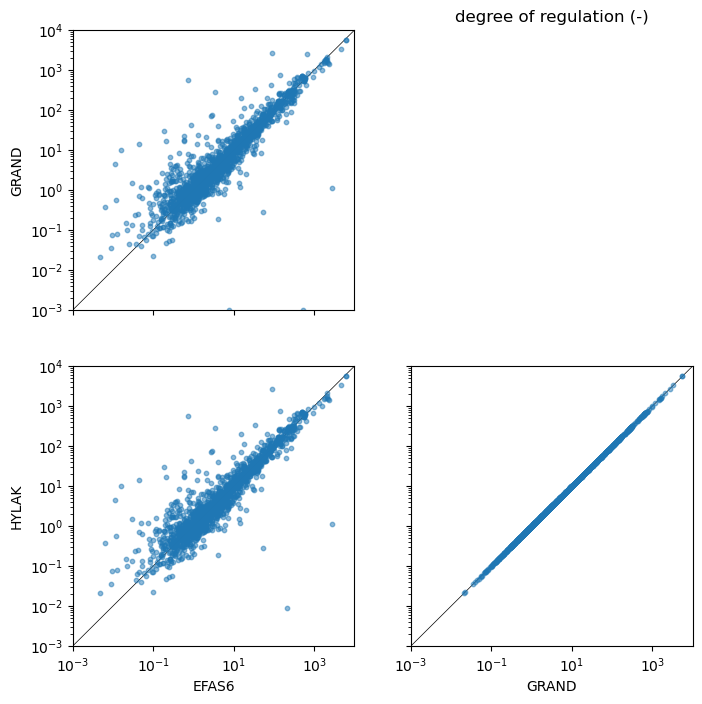

In [33]:
compare_attributes(
    dis_avg[['EFAS6', 'GRAND', 'HYLAK']],
    thr=0,
    vmin=0.001,
    vmax=1e4,
    title='degree of regulation (-)'
)
plt.savefig(PATH_OUT / 'plots' / 'dor_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values

I will use the values obtained from the attributes in EFAS6.

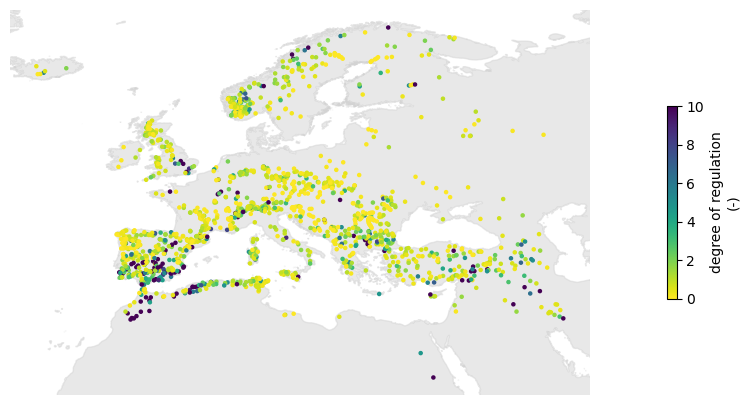

In [34]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=dor.EFAS6,
    cmap='viridis_r',
    s=5,
    vmin=0,
    vmax=10
)
cbar = plt.colorbar(sct, shrink=.5, label='degree of regulation\n(-)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dor_map.jpg', dpi=300, bbox_inches='tight')

In [35]:
efas6['DOR'] = dor.EFAS6.round(3)

print('{0} reservoirs do not comply with the minimum degree of regulation {1}'.format((efas6.DOR < MIN_DOR).sum(),
                                                                                       MIN_DOR))
print('{0} reservoirs have a degree of regulation larger than 10 years'.format((efas6.DOR > 10).sum()))

217 reservoirs do not comply with the minimum degree of regulation 0.08
96 reservoirs have a degree of regulation larger than 10 years


There are problems in the computation of the degree of regulation, inherited either from the reservoir storage or the average inflow. It's not realistic that 96 reservoirs were designed to store 10 years of inflow.

### 100-year return period

In [36]:
dis_100 = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'NAT_FLOW', 'LTR', 'EFAS6', 'SOURCE'], dtype=float)
dis_100.SOURCE = dis_100.SOURCE.astype(str)

# EFAS5
dis_100.loc[efas5.index, 'EFAS5'] = efas5.ndq
    
# EFAS5 natural flow
dis_max = dis_nat.groupby('time.year').max(dim='time')
thresholds = compute_thresholds_gumbel(dis_max, return_periods=[100], dim='year')
dis_100['NAT_FLOW'] = thresholds['rp_100'].to_pandas()

# EFAS5 long-run average
for ID, point in efas6.geometry.items():
    dis_100.loc[ID, 'LTR'] = dis_100_ltr.sel(x=point.x, y=point.y, method='nearest').item()

Computing Gumbel coefficients
Computing return periods


#### Comparison

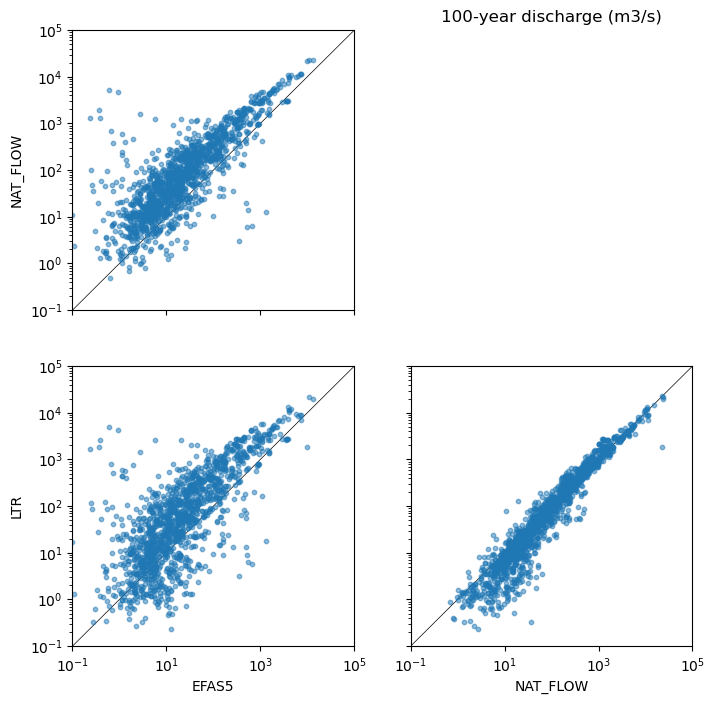

In [37]:
compare_attributes(
    dis_100[['EFAS5', 'NAT_FLOW', 'LTR']],
    thr=0,
    vmin=0.1,
    vmax=1e5,
    title='100-year discharge (m3/s)',
    # scale='linear'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_100_pairplot.jpg', dpi=300, bbox_inches='tight');

There is a great difference in the values of reservoir 1540 (GRanD 6851), a reservoir in the Nile.

In [38]:
(dis_100.NAT_FLOW / dis_100.EFAS5).median()

3.2774240533675227

The EFAS5 non-damaging flow must have been the 97th percentile of a previous EFAS run, so it's not exactely the 100-year return period computed here. The median difference between the 100-year inflow and the EFAS5 non-damaging flow is 3.2. Bear in mind that the flood outflow in the Hanazaki routine is by default 30% of the 100-year inflow, therefore overall similar values.

#### Select values

224 reservoirs have an 100-year inflow below 10 m3/s


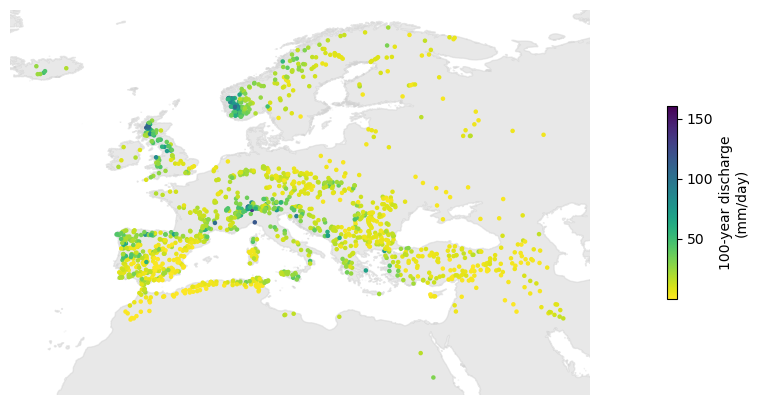

In [39]:
# select values from the EFAS5 naturalised run
dis_100.EFAS6 = dis_100.NAT_FLOW
dis_100.SOURCE = 'EFAS5_nat'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=dis_100.EFAS6 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='100-year discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_100_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[dis_100.index, 'DIS100_CMS'] = dis_100['EFAS6'].round(1).values

print('{0} reservoirs have an 100-year inflow below 10 m3/s'.format((efas6.DIS100_CMS < 10).sum()))

### Environment flow

In [40]:
dis_env = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'NAT_FLOW', 'D2', 'EFAS6', 'SOURCE'], dtype=float)
dis_env.SOURCE = dis_env.SOURCE.astype(str)

# EFAS5
dis_env.loc[efas5.index, 'EFAS5'] = efas5.minq

# EFAS5 natural flow
dis_env['NAT_FLOW'] = dis_nat.sel(time=slice('2000-01-01', None)).quantile(.1, dim='time').to_pandas()

# EFAS5 naturalised run
for ID, point in efas6.geometry.items():
    dis_env.loc[ID, 'D2'] = dis_env_nat.sel(lon=point.x, lat=point.y, method='nearest').item()

In [41]:
dis_env.describe()

,EFAS5,NAT_FLOW,D2,EFAS6
count,1393.000000,1.545000e+03,1545.000000,0.0
mean,21.614135,2.709148e+01,27.140356,NaN
std,166.788081,1.553446e+02,155.294240,NaN
min,0.000000,7.864177e-12,0.000729,NaN
25%,0.200000,1.309720e-02,0.105030,NaN
50%,0.570000,4.378767e-01,0.557313,NaN
75%,3.140000,4.063338e+00,4.238357,NaN
max,3327.770000,3.098735e+03,3097.585938,NaN


#### Comparison

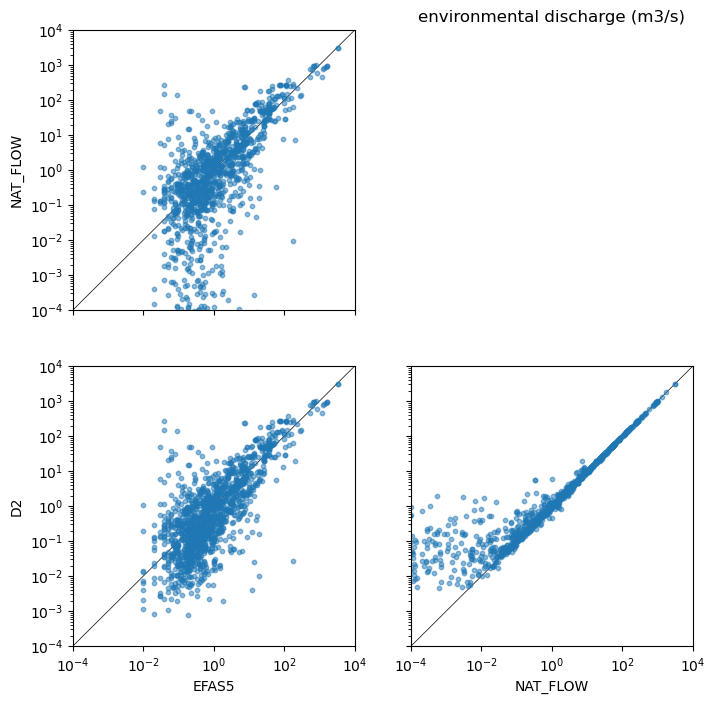

In [42]:
compare_attributes(
    dis_env[['EFAS5', 'NAT_FLOW', 'D2']],
    thr=0,
    vmin=1e-4,
    vmax=1e4,
    title='environmental discharge (m3/s)',
    # scale='linear'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_env_pairplot.jpg', dpi=300, bbox_inches='tight');

#### Select values

I will select the values extracted from the D2 map, as it limits extremely low values.

375 reservoirs have an environmental flow below 0.1 m3/s


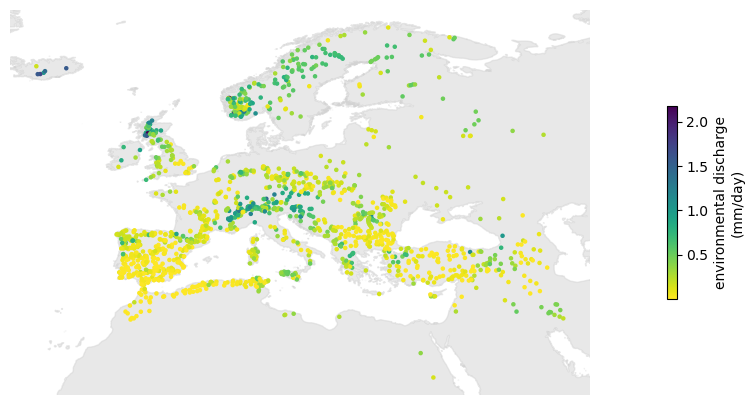

In [43]:
# select values from the EFAS5 naturalised run
dis_env.EFAS6 = dis_env.D2
dis_env.SOURCE = 'EFAS5_nat'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=dis_env.EFAS6 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='environmental discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_env_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[dis_env.index, 'DISENV_CMS'] = dis_env['EFAS6'].round(4).values

print('{0} reservoirs have an environmental flow below 0.1 m3/s'.format((efas6.DISENV_CMS < 0.1).sum()))

There are very low values of environmental flow.

## Export
### Excel file

In [116]:
# copy efas6 as main source
reservoirs = efas6.copy()

# LISFLOOD coordinates
reservoirs['LisfloodX'] = reservoirs.geometry.x
reservoirs['LisfloodY'] = reservoirs.geometry.y

# source of discharge data
reservoirs['DIS_SRC'] = 'EFAS5_natflow'

# add data from GRanD
grand_ids = reservoirs.GRanD_id.dropna()
grand_cols = ['RES_NAME', 'DAM_NAME', 'RIVER', 'MAIN_BASIN', 'COUNTRY', 'YEAR', 'LONG_DD', 'LAT_DD']
reservoirs.loc[grand_ids.index, grand_cols] = grand.loc[grand_ids.values, grand_cols].values

# add info from EFAS5
ids = reservoirs[reservoirs.GRanD_id.isnull() & reservoirs.ResID.notnull()].index
cols_efas5 = ['COUNTRY', 'DAM_NAME']
reservoirs.loc[ids, cols_efas5] = efas5.loc[ids, cols_efas5]

# reorder and rename columns
cols = ['ResID', 'GRanD_id', 'Hylak_id', 'ICOLD_id', 
        'RES_NAME', 'DAM_NAME', 'RIVER', 'MAIN_BASIN', 'COUNTRY', 'YEAR',
        'LONG_DD', 'LAT_DD', 'LisfloodX', 'LisfloodY',
        'CAP_MCM', 'CAP_SRC', 'CATCH_SKM', 'CATCH_SRC', 'AREA_SKM', 'AREA_SRC', 'DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS', 'DIS_SRC', 'DOR',
        'geometry']
reservoirs = reservoirs[cols]

# adapt dtypes
reservoirs.YEAR = reservoirs.YEAR.astype('Int64')

# reset index
# reservoirs['FID'] = np.arange(1, reservoirs.shape[0] + 1)
# reservoirs.loc[reservoirs.ResID > 5000, 'FID'] = reservoirs.loc[reservoirs.ResID > 5000, 'ResID']
idx = []
i = 6000
for res_id in reservoirs.ResID.values:
    if pd.isna(res_id):
        i += 1
        idx.append(i)
    else:
        idx.append(res_id)
reservoirs['FID'] = idx
reservoirs.set_index('FID', drop=True, inplace=True)
reservoirs.sort_index(axis=0, inplace=True)

In [117]:
mask_res = (reservoirs.DOR >= MIN_DOR) | ((reservoirs.index > 5000) & (reservoirs.index < 6000)) | (reservoirs.AREA_SKM.isnull())
print('{0} reservoirs will be modelled as lakes'.format((~mask_res).sum()))

209 reservoirs will be modelled as lakes


In [120]:
with pd.ExcelWriter(PATH_OUT / 'efas6_reservoirs.xlsx', engine='openpyxl') as writer:
    # Reservoirs in EFAS6 (as reservoirs)
    reservoirs[mask_res].drop('geometry', axis=1).to_excel(writer, sheet_name='as_reservoirs', float_format='%.4f')
    
    # Reservoirs modeled as lakes in EFAS6 (as lakes)
    reservoirs[~mask_res].drop('geometry', axis=1).to_excel(writer, sheet_name='as_lakes', float_format='%.4f')

### TXT tables

In [10]:
# filter reservoirs to be modelled as reservoirs
res = pd.read_excel(PATH_OUT / 'efas6_reservoirs.xlsx', sheet_name='as_reservoirs', index_col='FID')
# res = reservoirs[mask_res]

# table reservoir capacity
(res.CAP_MCM * 1e6).to_csv(
    PATH_OUT / 'reservoirs_efas6_capacity.txt',
    sep='\t',
    header=None,
    float_format='%.0f'
)

# table environmental flow
res.DISENV_CMS.round(1).to_csv(
    PATH_OUT / 'reservoirs_efas6_env_flow.txt',
    sep='\t',
    header=None
)

# table average discharge
res.DISAVG_CMS.round(1).to_csv(
    PATH_OUT / 'reservoirs_efas6_avg_inflow.txt',
    sep='\t',
    header=None
)

# table 100-year discharge
res.DIS100_CMS.round(1).to_csv(
    PATH_OUT / 'reservoirs_efas6_100yr_inflow.txt',
    sep='\t',
    header=None
)

### NetCDF map

In [7]:
# load map from GloFAS4
mapa = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'res_European_01min.nc')#.squeeze(dim='band').astype(int)
mapa.close()

# remove all lakes
mapa[:,:] = 0

# assign IDs of lakes in GloFAS5
for ID, row in tqdm(res.iterrows(), total=len(res)):
    pixel = mapa.sel({'x': row.LisfloodX, 'y': row.LisfloodY}, method='nearest')
    mapa.loc[{'x': pixel.x.item(), 'y': pixel.y.item()}] = ID

  0%|          | 0/1336 [00:00<?, ?it/s]

In [11]:
# modify attributes
mapa.attrs['contributors'] = 'Juliana Disperati <juliana.disperati@ext.ec.europa.eu'
mapa.attrs['creator'] = 'Jesús Casado Rodríguez <jesus.casado-rodriguez@ec.europa.eu'
mapa.attrs['creator_name'] = 'casadje'
mapa.attrs['history'] = ('Created {0}'.format(datetime.now().strftime("%a %b %e %H:%M:%S %Y")))
mapa.attrs['history_of_appended_files'] = ''
mapa.attrs['institution'] = 'Joint Research Centre - European Commission'
mapa.attrs['references'] = 'https://www.globaldamwatch.org/grand'
mapa.attrs['long_name'] = 'reservoirs'

# define coordinate reference system
mapa = mapa.rio.write_crs('EPSG:4326')

# export NetCDF map
mapa.rio.to_raster(PATH_OUT / 'reservoirs_efas6_01min.nc')